In [1]:
# Step 1: Data Loading and Exploration

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import Lasso
from sklearn.metrics import mean_squared_error

In [3]:
# Load the datasets
train_df = pd.read_csv('train.csv')
test_df = pd.read_csv('test.csv')
data_description = open('data_description.txt').read()

# Display basic information about the training data
print(train_df.info())



<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 81 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Id             1460 non-null   int64  
 1   MSSubClass     1460 non-null   int64  
 2   MSZoning       1460 non-null   object 
 3   LotFrontage    1201 non-null   float64
 4   LotArea        1460 non-null   int64  
 5   Street         1460 non-null   object 
 6   Alley          91 non-null     object 
 7   LotShape       1460 non-null   object 
 8   LandContour    1460 non-null   object 
 9   Utilities      1460 non-null   object 
 10  LotConfig      1460 non-null   object 
 11  LandSlope      1460 non-null   object 
 12  Neighborhood   1460 non-null   object 
 13  Condition1     1460 non-null   object 
 14  Condition2     1460 non-null   object 
 15  BldgType       1460 non-null   object 
 16  HouseStyle     1460 non-null   object 
 17  OverallQual    1460 non-null   int64  
 18  OverallC

In [4]:
print(train_df.describe())

                Id   MSSubClass  LotFrontage        LotArea  OverallQual  \
count  1460.000000  1460.000000  1201.000000    1460.000000  1460.000000   
mean    730.500000    56.897260    70.049958   10516.828082     6.099315   
std     421.610009    42.300571    24.284752    9981.264932     1.382997   
min       1.000000    20.000000    21.000000    1300.000000     1.000000   
25%     365.750000    20.000000    59.000000    7553.500000     5.000000   
50%     730.500000    50.000000    69.000000    9478.500000     6.000000   
75%    1095.250000    70.000000    80.000000   11601.500000     7.000000   
max    1460.000000   190.000000   313.000000  215245.000000    10.000000   

       OverallCond    YearBuilt  YearRemodAdd   MasVnrArea   BsmtFinSF1  ...  \
count  1460.000000  1460.000000   1460.000000  1452.000000  1460.000000  ...   
mean      5.575342  1971.267808   1984.865753   103.685262   443.639726  ...   
std       1.112799    30.202904     20.645407   181.066207   456.098091  ..

In [5]:
# Step 2: Data Preprocessing

# Identify numerical and categorical columns
numerical_cols = train_df.select_dtypes(include=['int64', 'float64']).columns
categorical_cols = train_df.select_dtypes(include=['object']).columns

# Handle missing values and encoding
numerical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])

categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numerical_transformer, numerical_cols),
        ('cat', categorical_transformer, categorical_cols)
    ])



In [8]:
# Key features to consider
key_features = [
    'OverallQual', 'GrLivArea', 'YearBuilt', 'YearRemodAdd', 'TotalBsmtSF',
    '1stFlrSF', 'FullBath', 'GarageCars', 'GarageArea', 'LotArea',
    'Neighborhood', 'KitchenQual', 'TotRmsAbvGrd', 'Fireplaces'
]

# Create new features
train_df['HouseAge'] = train_df['YrSold'] - train_df['YearBuilt']
train_df['RemodAge'] = train_df['YrSold'] - train_df['YearRemodAdd']
train_df['TotalBath'] = train_df['FullBath'] + (0.5 * train_df['HalfBath']) + train_df['BsmtFullBath'] + (0.5 * train_df['BsmtHalfBath'])
train_df['TotalSF'] = train_df['TotalBsmtSF'] + train_df['1stFlrSF'] + train_df['2ndFlrSF']

test_df['HouseAge'] = test_df['YrSold'] - test_df['YearBuilt']
test_df['RemodAge'] = test_df['YrSold'] - test_df['YearRemodAdd']
test_df['TotalBath'] = test_df['FullBath'] + (0.5 * test_df['HalfBath']) + test_df['BsmtFullBath'] + (0.5 * test_df['BsmtHalfBath'])
test_df['TotalSF'] = test_df['TotalBsmtSF'] + test_df['1stFlrSF'] + test_df['2ndFlrSF']

# Update key_features list
key_features.extend(['HouseAge', 'RemodAge', 'TotalBath', 'TotalSF'])

# Identify numerical and categorical columns
numerical_cols = train_df[key_features].select_dtypes(include=['int64', 'float64']).columns
categorical_cols = train_df[key_features].select_dtypes(include=['object']).columns



In [9]:
# Handle missing values and encoding
numerical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])

categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numerical_transformer, numerical_cols),
        ('cat', categorical_transformer, categorical_cols)
    ])

In [10]:
# Split the data into training and validation sets using key features
X = train_df[key_features]
y = train_df['SalePrice']
X_train, X_valid, y_train, y_valid = train_test_split(X, y, train_size=0.8, test_size=0.2, random_state=0)

# Create a pipeline that includes preprocessing and model training
model = Pipeline(steps=[('preprocessor', preprocessor),
                        ('model', RandomForestRegressor(n_estimators=100, random_state=0))])

# Train the model
model.fit(X_train, y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  Index(['OverallQual', 'GrLivArea', 'YearBuilt', 'YearRemodAdd', 'TotalBsmtSF',
       '1stFlrSF', 'FullBath', 'GarageCars', 'GarageArea', 'LotArea',
       'TotRmsAbvGrd', 'Fireplaces', 'HouseAge', 'RemodAge', 'TotalBath',
       'TotalSF'],
      dtype='object')),
                                                 ('cat',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('onehot',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  Index(['Neighborhood', 'KitchenQual'], dtype='object'))])),
                ('model', RandomForestRegressor(random_state=0))])

In [11]:
# Step 5: Model Evaluation

# Make predictions and evaluate the model
y_pred = model.predict(X_valid)
mse = mean_squared_error(y_valid, y_pred)
rmse = np.sqrt(mse)
print(f'Validation RMSE: {rmse}')

Validation RMSE: 30676.115014294803


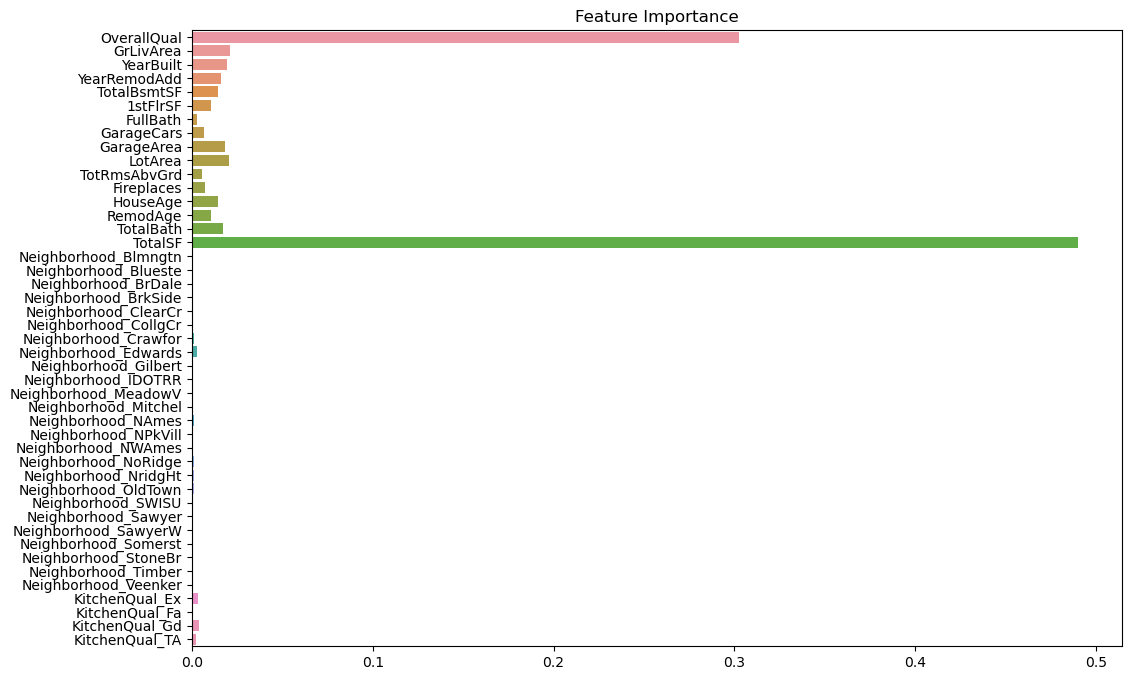

In [12]:
# Visualize feature importance
feature_importance = model.named_steps['model'].feature_importances_
feature_names = np.concatenate([numerical_cols, model.named_steps['preprocessor'].transformers_[1][1].named_steps['onehot'].get_feature_names_out(categorical_cols)])

plt.figure(figsize=(12, 8))
sns.barplot(x=feature_importance, y=feature_names)
plt.title('Feature Importance')
plt.show()


In [13]:
X_test = test_df[key_features]
preds_test = model.predict(X_test)


In [14]:
submission = pd.DataFrame({'Id': test_df['Id'], 'SalePrice': preds_test})
submission.to_csv('submission.csv', index=False)

In [15]:
y_pred = model.predict(X_valid)
mse = mean_squared_error(y_valid, y_pred)
print(mse)

941024032.3702431


              Actual      Predicted          Error  Absolute Error
count     292.000000     292.000000     292.000000      292.000000
mean   181370.383562  182372.427694   -1002.044132    17875.883402
std     83244.107342   78050.731178   30712.379410    24972.234265
min     67000.000000   65154.110000 -258842.310000       58.520000
25%    128875.000000  130353.852500  -12055.790000     4186.600000
50%    163950.000000  166730.185000     -55.050000    11405.765000
75%    203573.750000  214107.200000   10885.362500    21036.290000
max    745000.000000  606688.880000  168459.980000   258842.310000


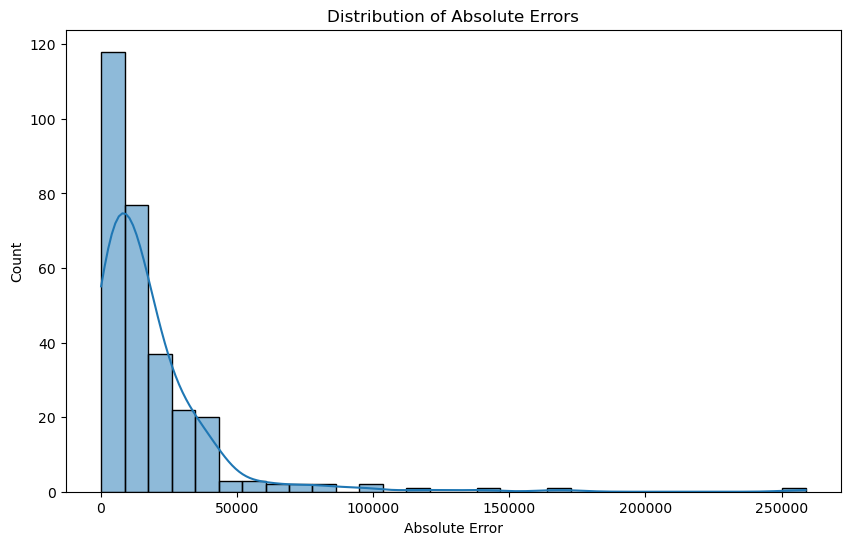

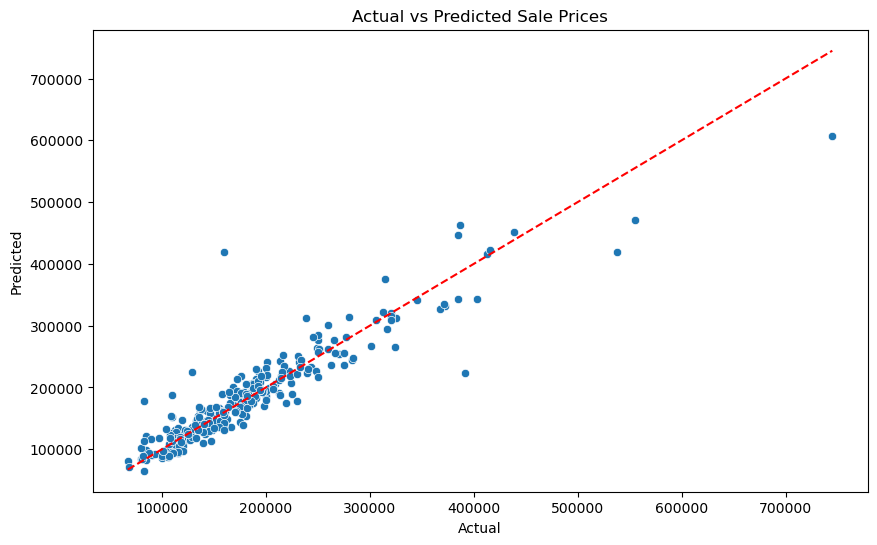

In [16]:
# Create a DataFrame to compare actual vs predicted values
comparison_df = pd.DataFrame({'Actual': y_valid, 'Predicted': y_pred})
comparison_df['Error'] = comparison_df['Actual'] - comparison_df['Predicted']
comparison_df['Absolute Error'] = comparison_df['Error'].abs()

# Analyze the errors
print(comparison_df.describe())

# Visualize the errors
plt.figure(figsize=(10, 6))
sns.histplot(comparison_df['Absolute Error'], bins=30, kde=True)
plt.title('Distribution of Absolute Errors')
plt.show()

# Scatter plot of Actual vs Predicted values
plt.figure(figsize=(10, 6))
sns.scatterplot(x='Actual', y='Predicted', data=comparison_df)
plt.plot([min(comparison_df['Actual']), max(comparison_df['Actual'])], [min(comparison_df['Actual']), max(comparison_df['Actual'])], color='red', linestyle='--')
plt.title('Actual vs Predicted Sale Prices')
plt.show()
